In [740]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split
import seaborn as sns
from pandas.plotting import lag_plot
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from pmdarima import acf
from math import sqrt
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima.arima.utils import ndiffs

In [741]:
df = pd.read_csv('C:/Users/norri/Desktop/amazon_full.csv', parse_dates=['week'])
df = df[df['client_name'] == 'KIND']
df = df.drop_duplicates(subset=['sales', 'week'])
df['week'] = df['week'] = pd.to_datetime(df['week'])
df = df.sort_values(by=['week'])
df['sales'] = df['sales'].values
df = df.drop(columns=['brand_name', 'campaign_type', 'client_name'])

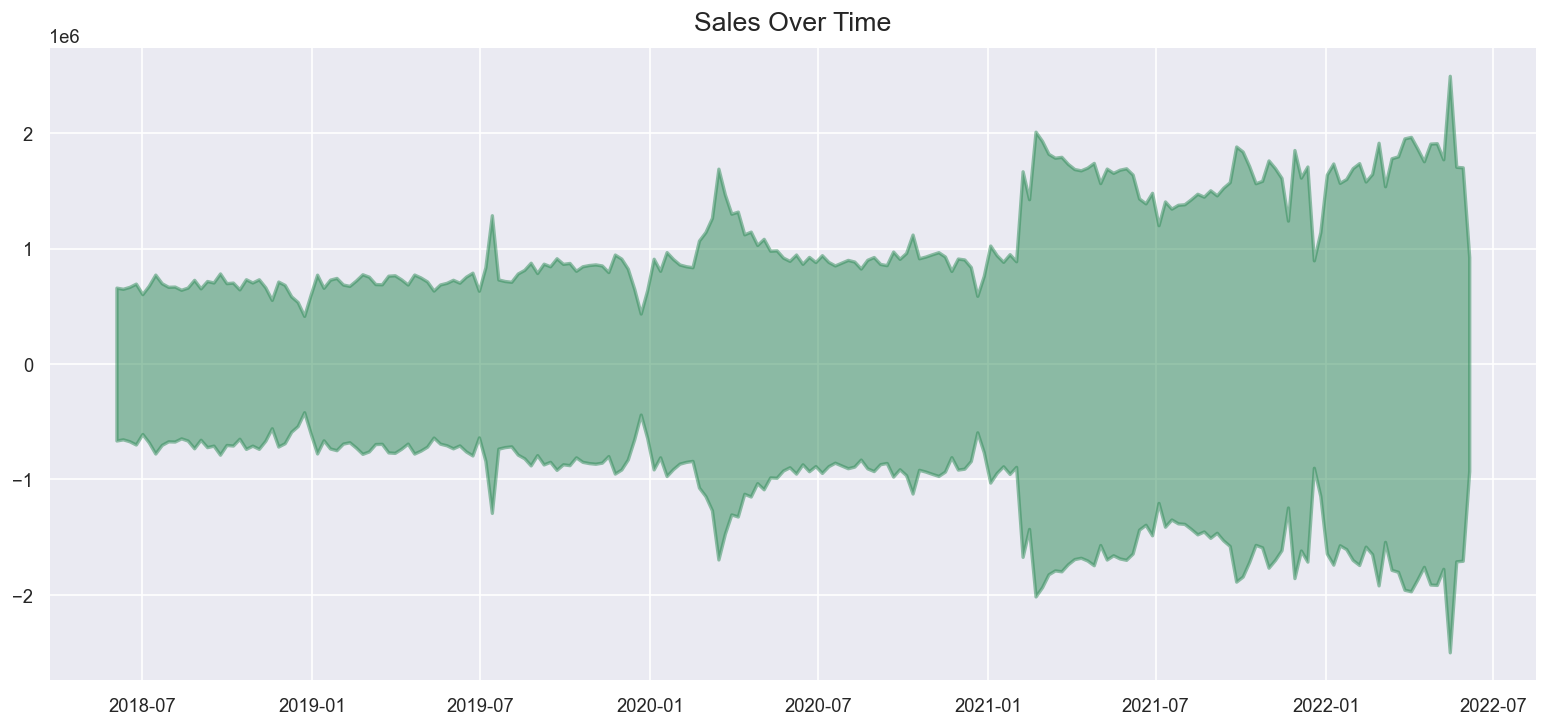

In [742]:
fig, ax = plt.subplots(1, 1, figsize=(16,7), dpi= 120)
plt.fill_between(df['week'], y1=df['sales'], y2=-df['sales'], alpha=0.5, linewidth=2, color='seagreen')
plt.title('Sales Over Time', fontsize=16)
plt.show()

In [743]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Sales', dpi=100):
    plt.figure(figsize=(13, 13), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

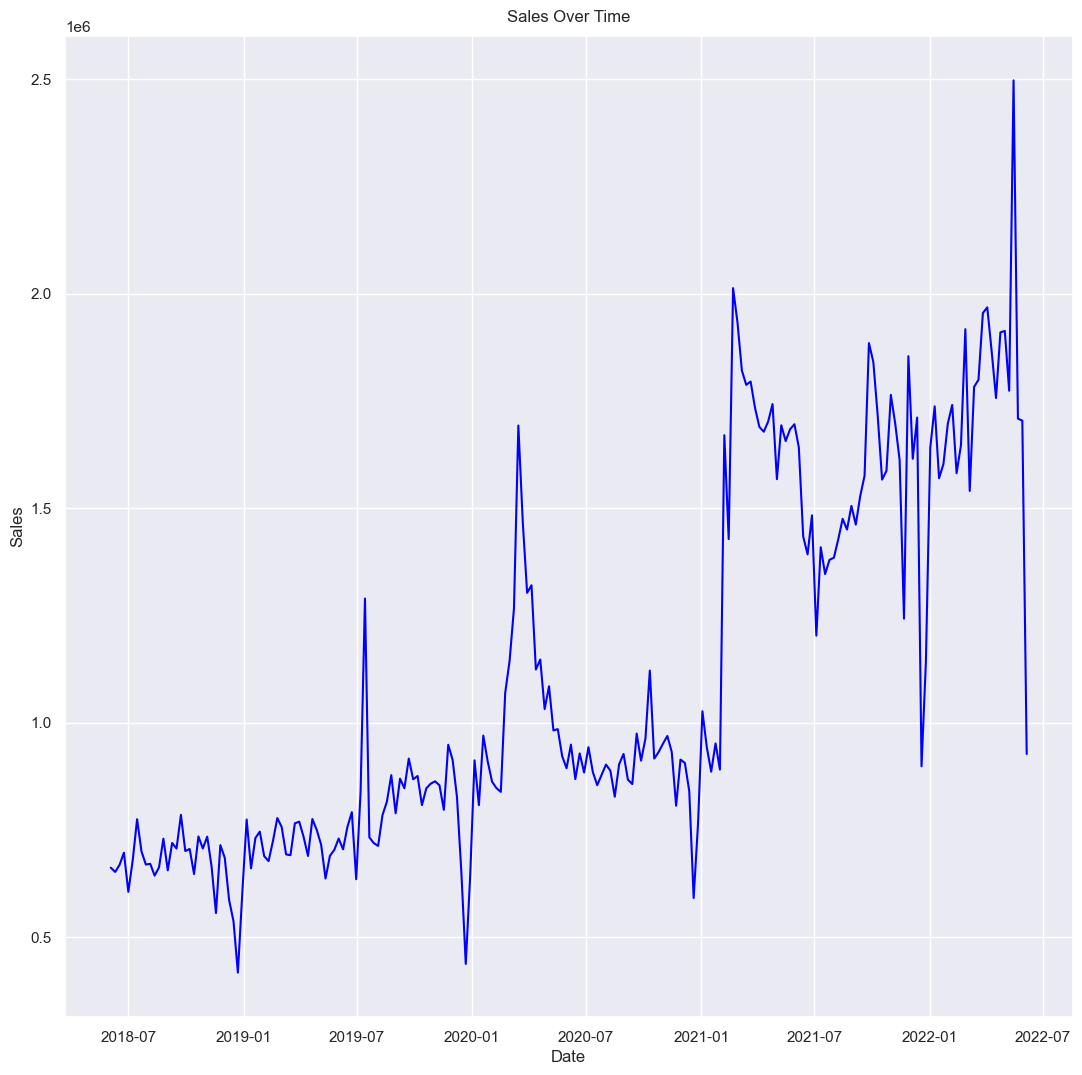

In [744]:
plot_df(df, df['week'], df['sales'], title='Sales Over Time')

Both plots appear to demonstrate a slight degree of annual cycles

Value = Base Level + Trend + Seasonality + Error - Additive Decomposition
Value = Base Level x Trend x Seasonality x Error - Multiplicative Decompisition

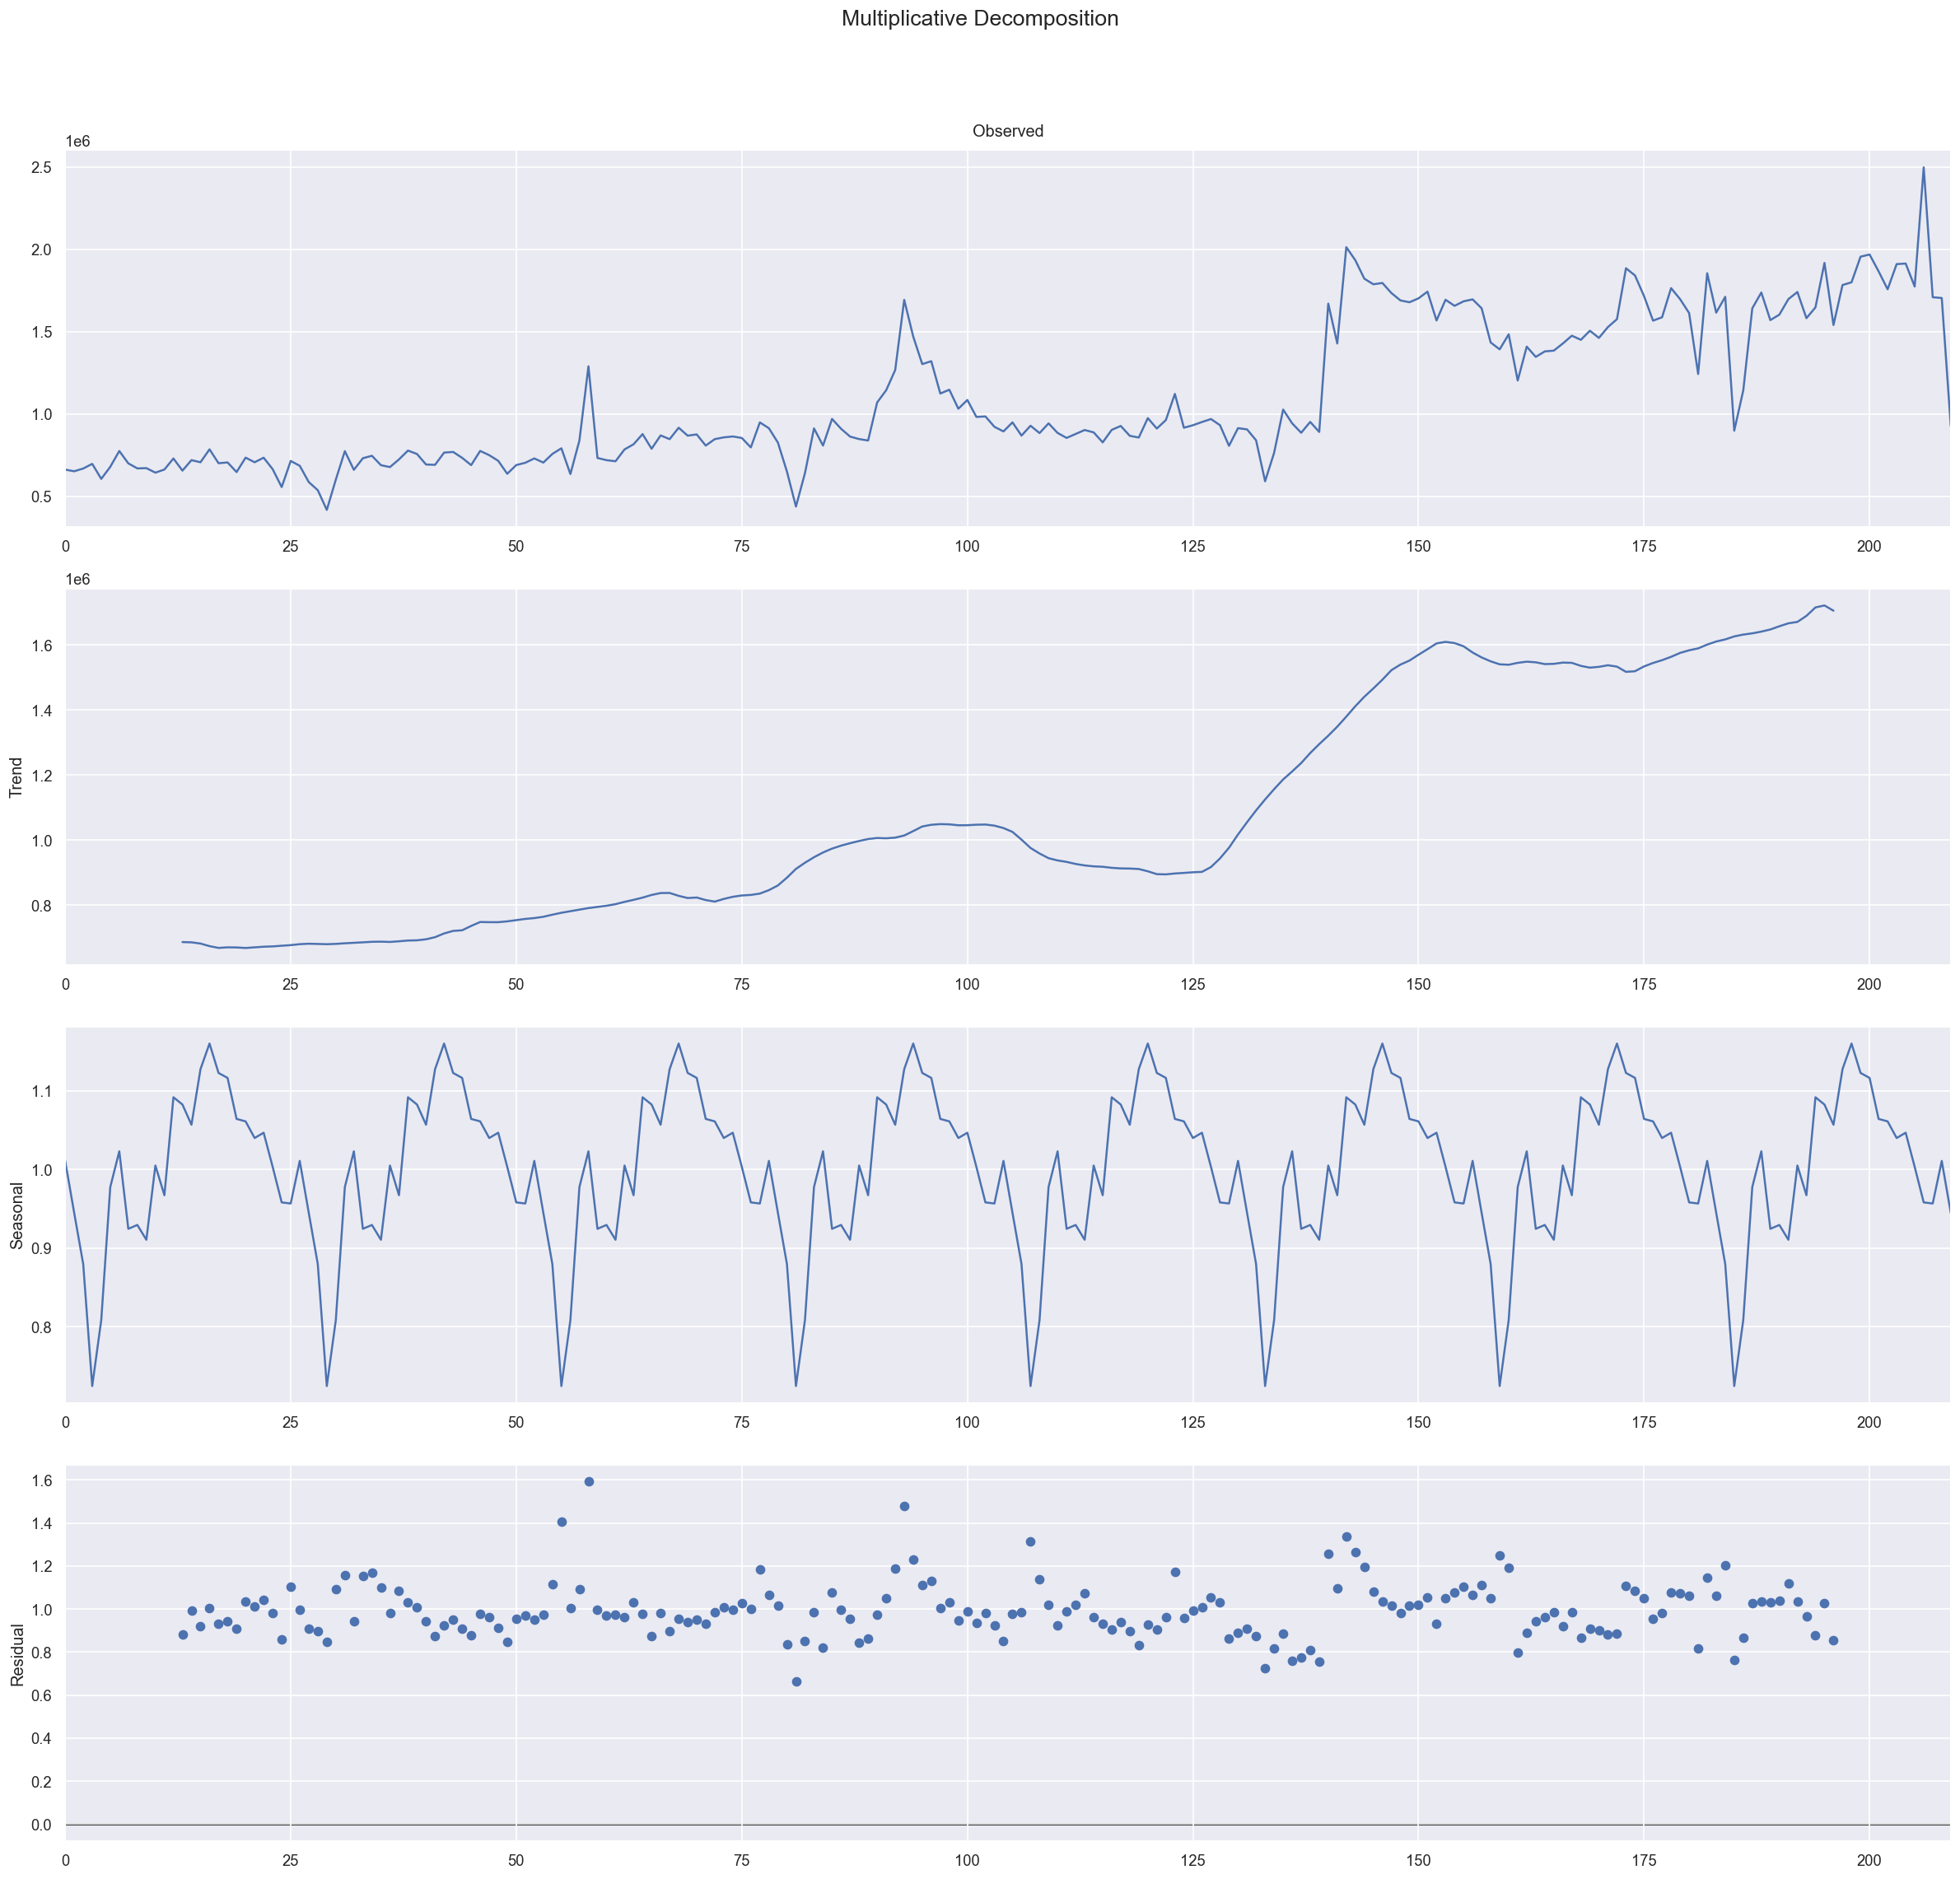

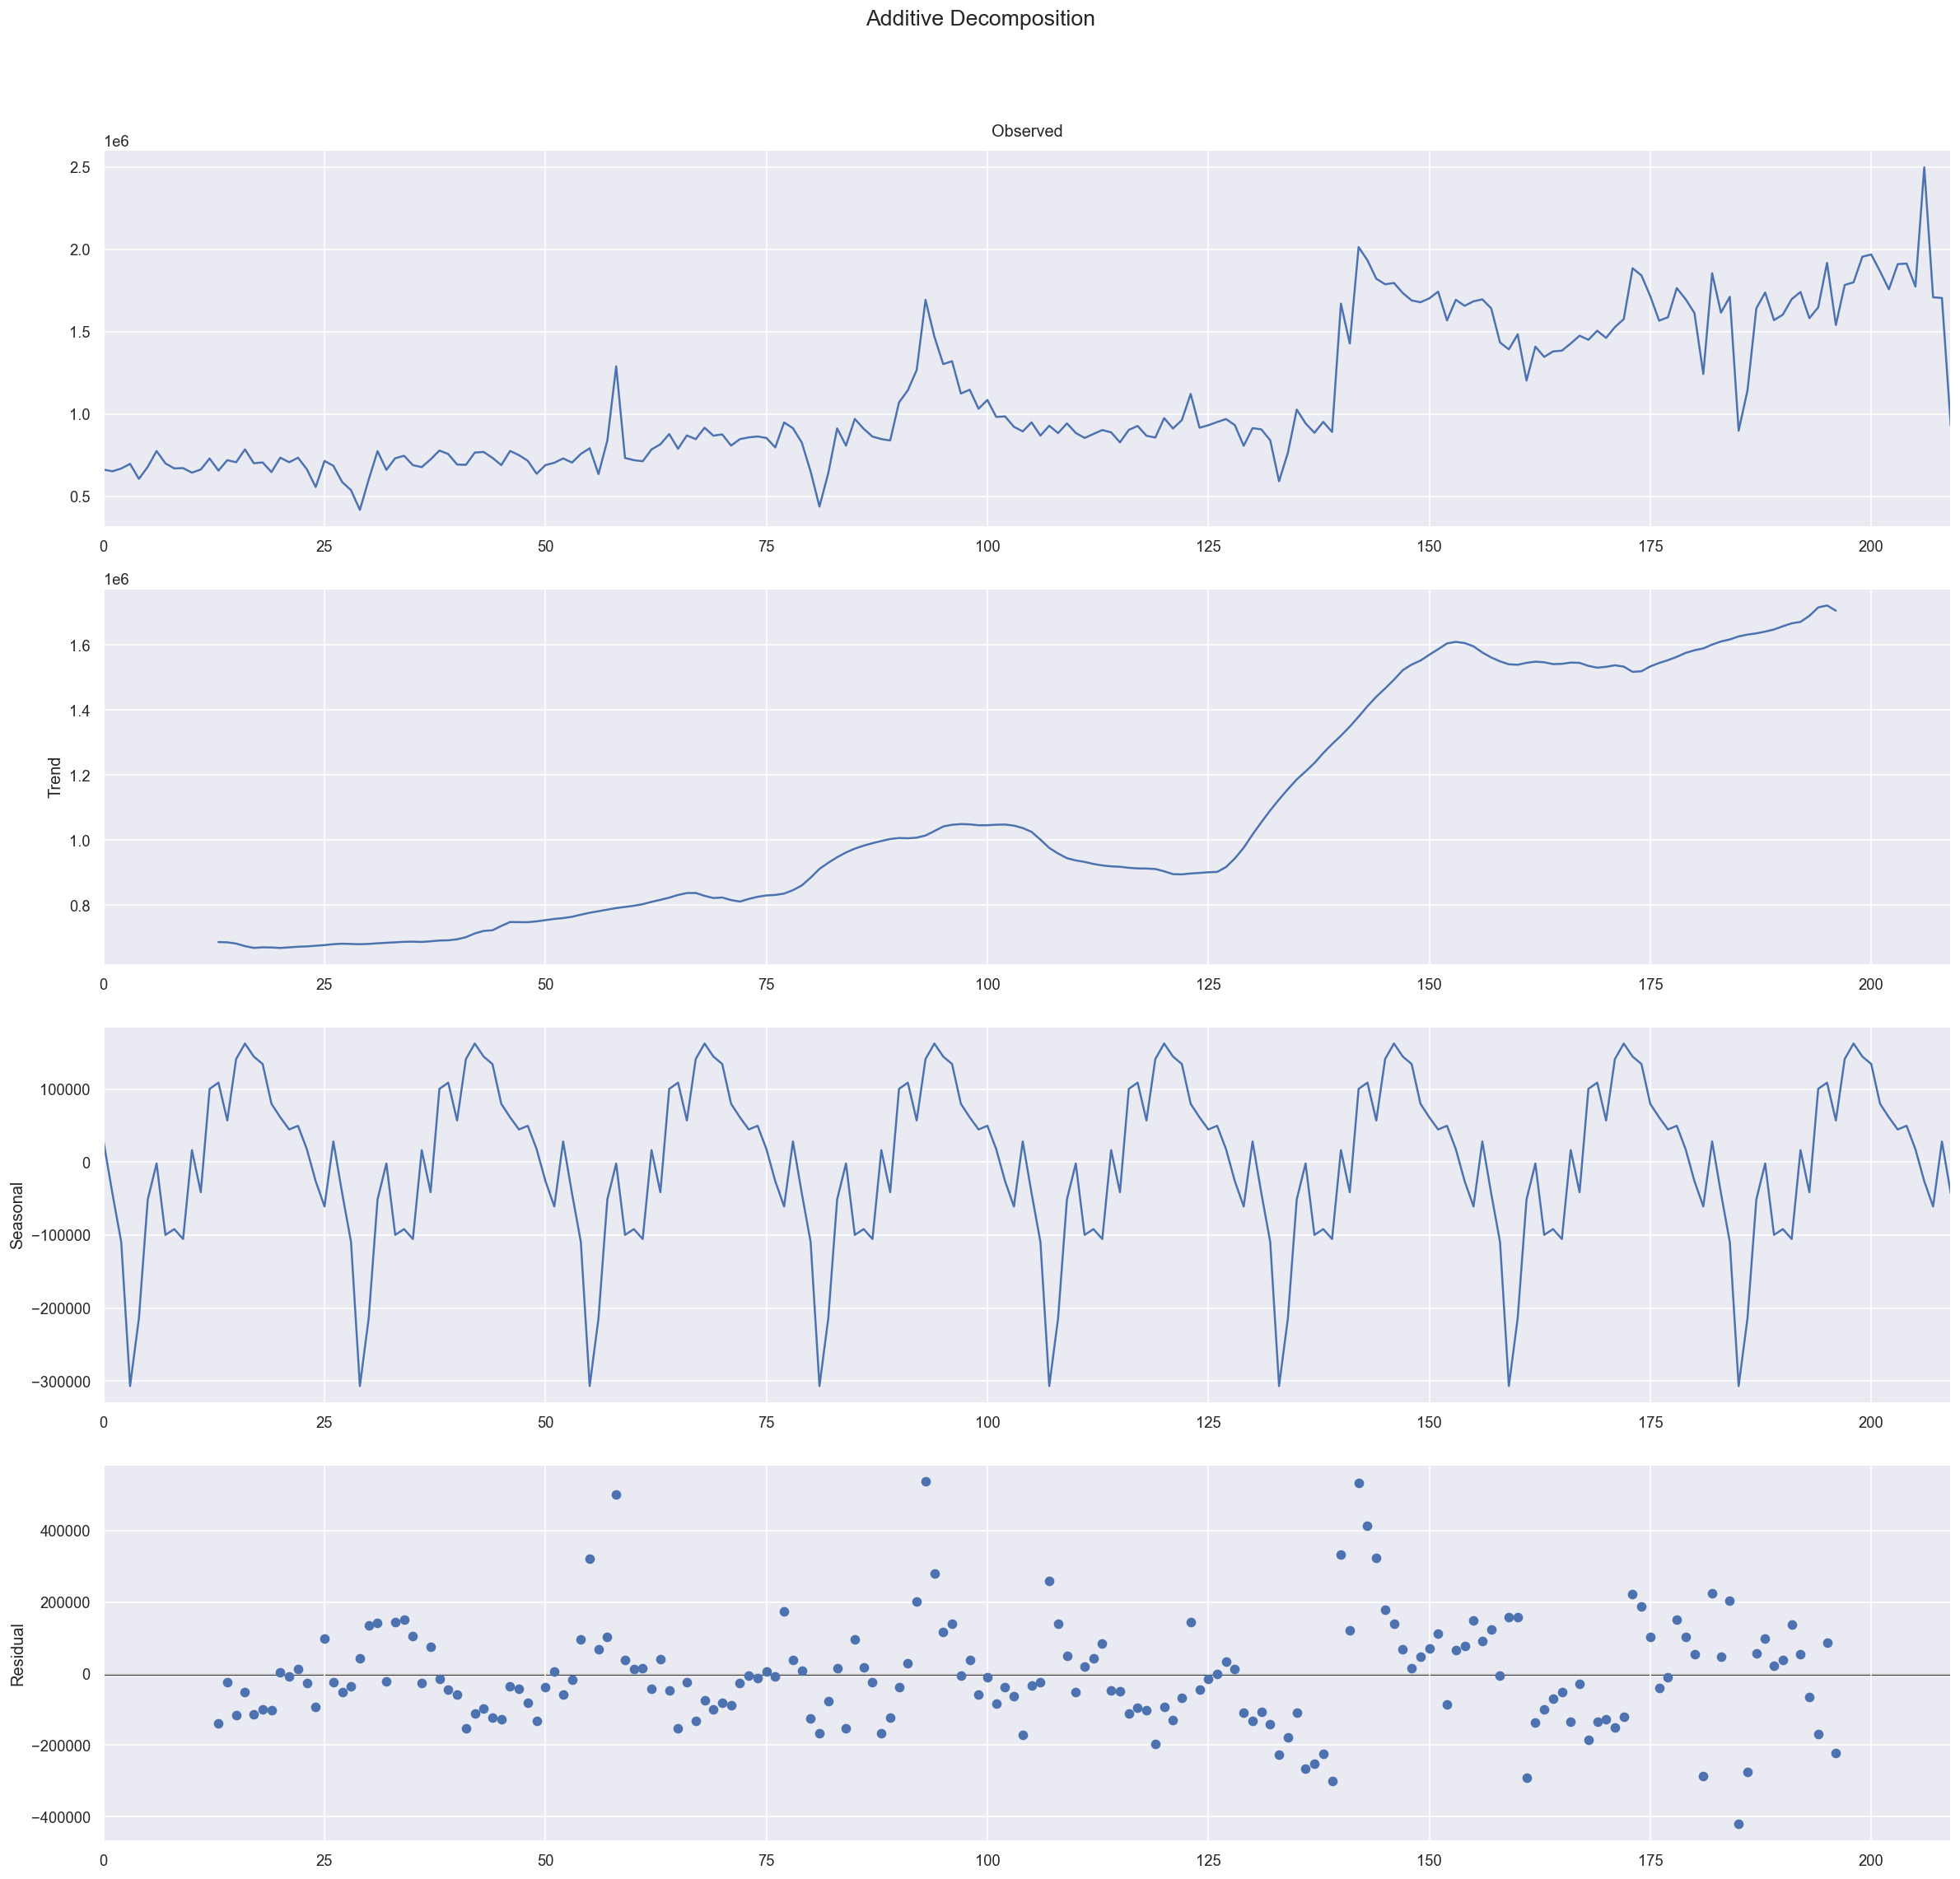

In [745]:
multiplicative_decomposition = seasonal_decompose(df['sales'].values,
                                                  model='multiplicative',
                                                  period=26)
additive_decomposition = seasonal_decompose(df['sales'].values, model='additive',
                                            period=26)
plt.rcParams.update({'figure.figsize': (20,20)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Variance of Residuals appear to be random and similar between additive and multiplicative

Text(0.5, 1.0, 'Sales Detrended')

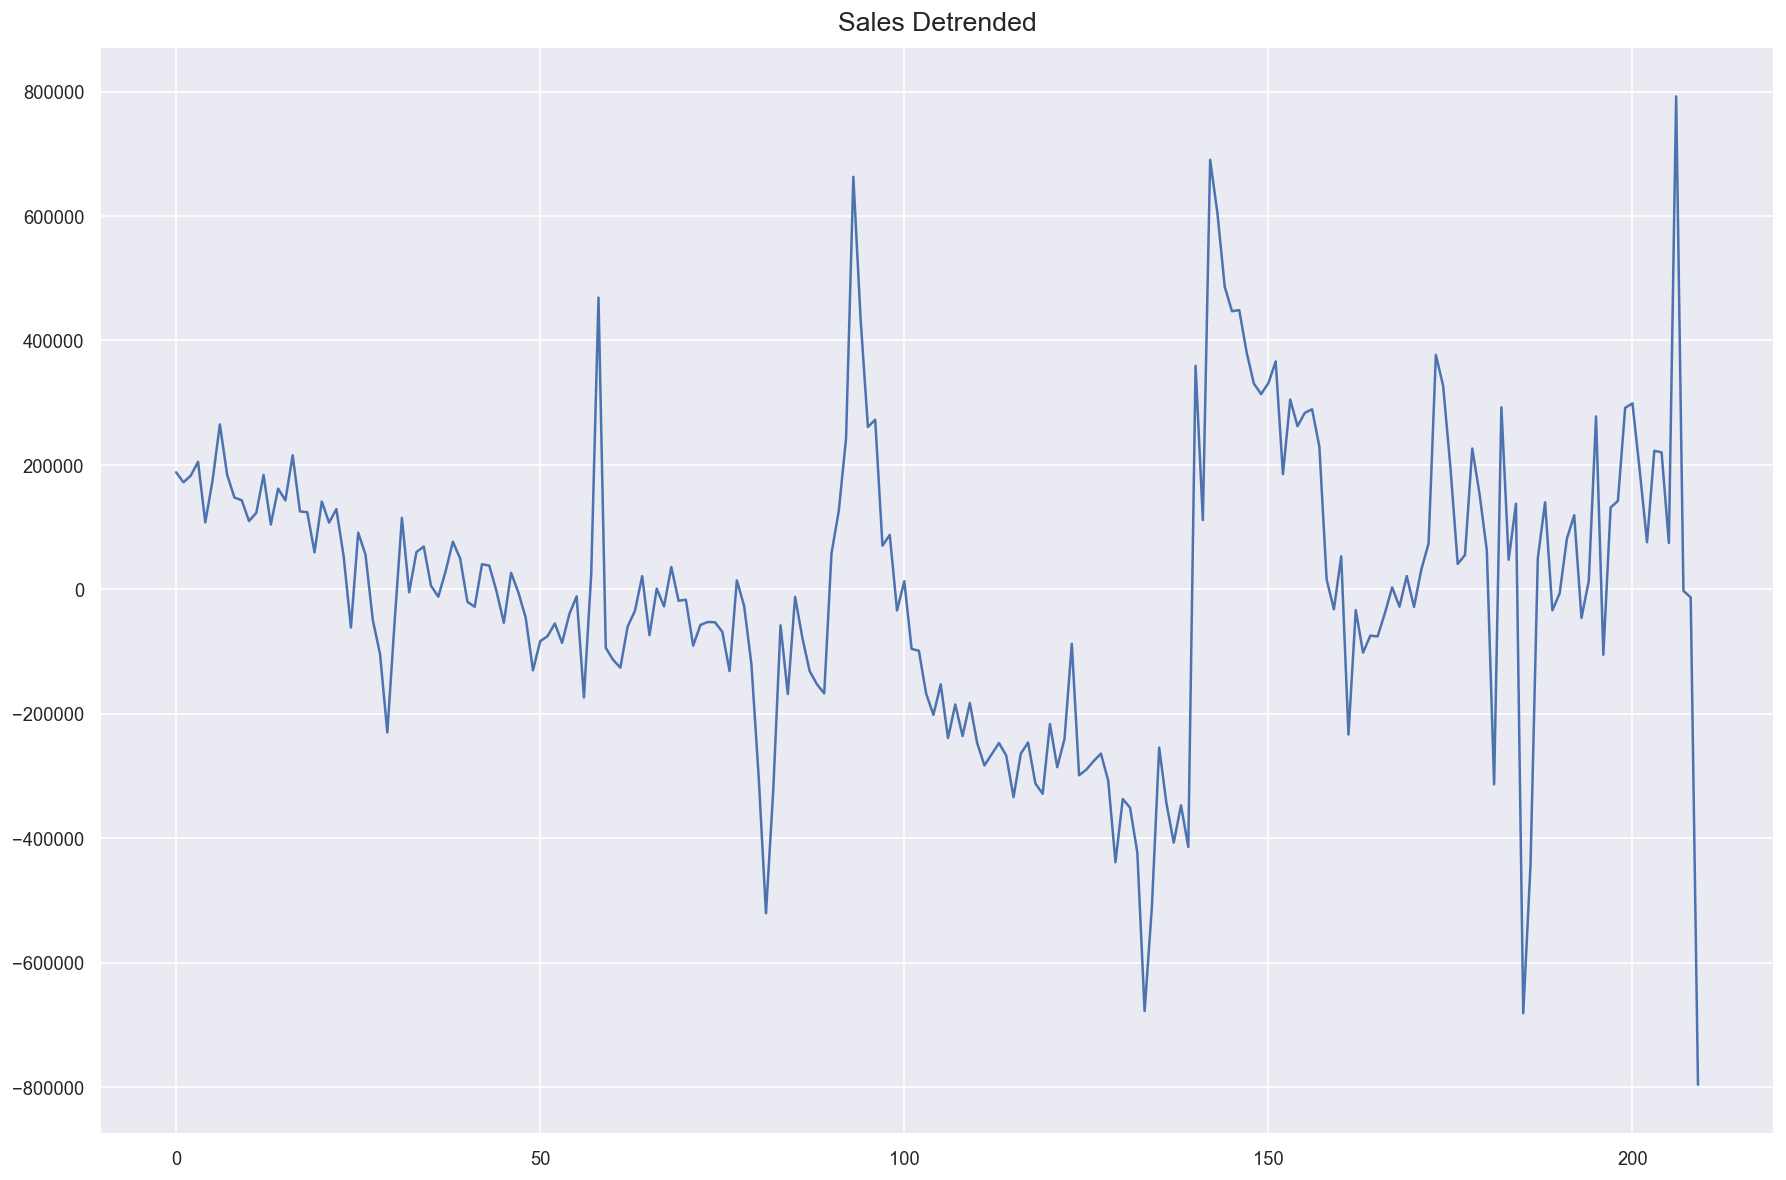

In [746]:
detrended = signal.detrend(df['sales'].values)
plt.rcParams.update({'figure.figsize': (18,12)})
plt.plot(detrended)
plt.title('Sales Detrended', fontsize=16)

[]

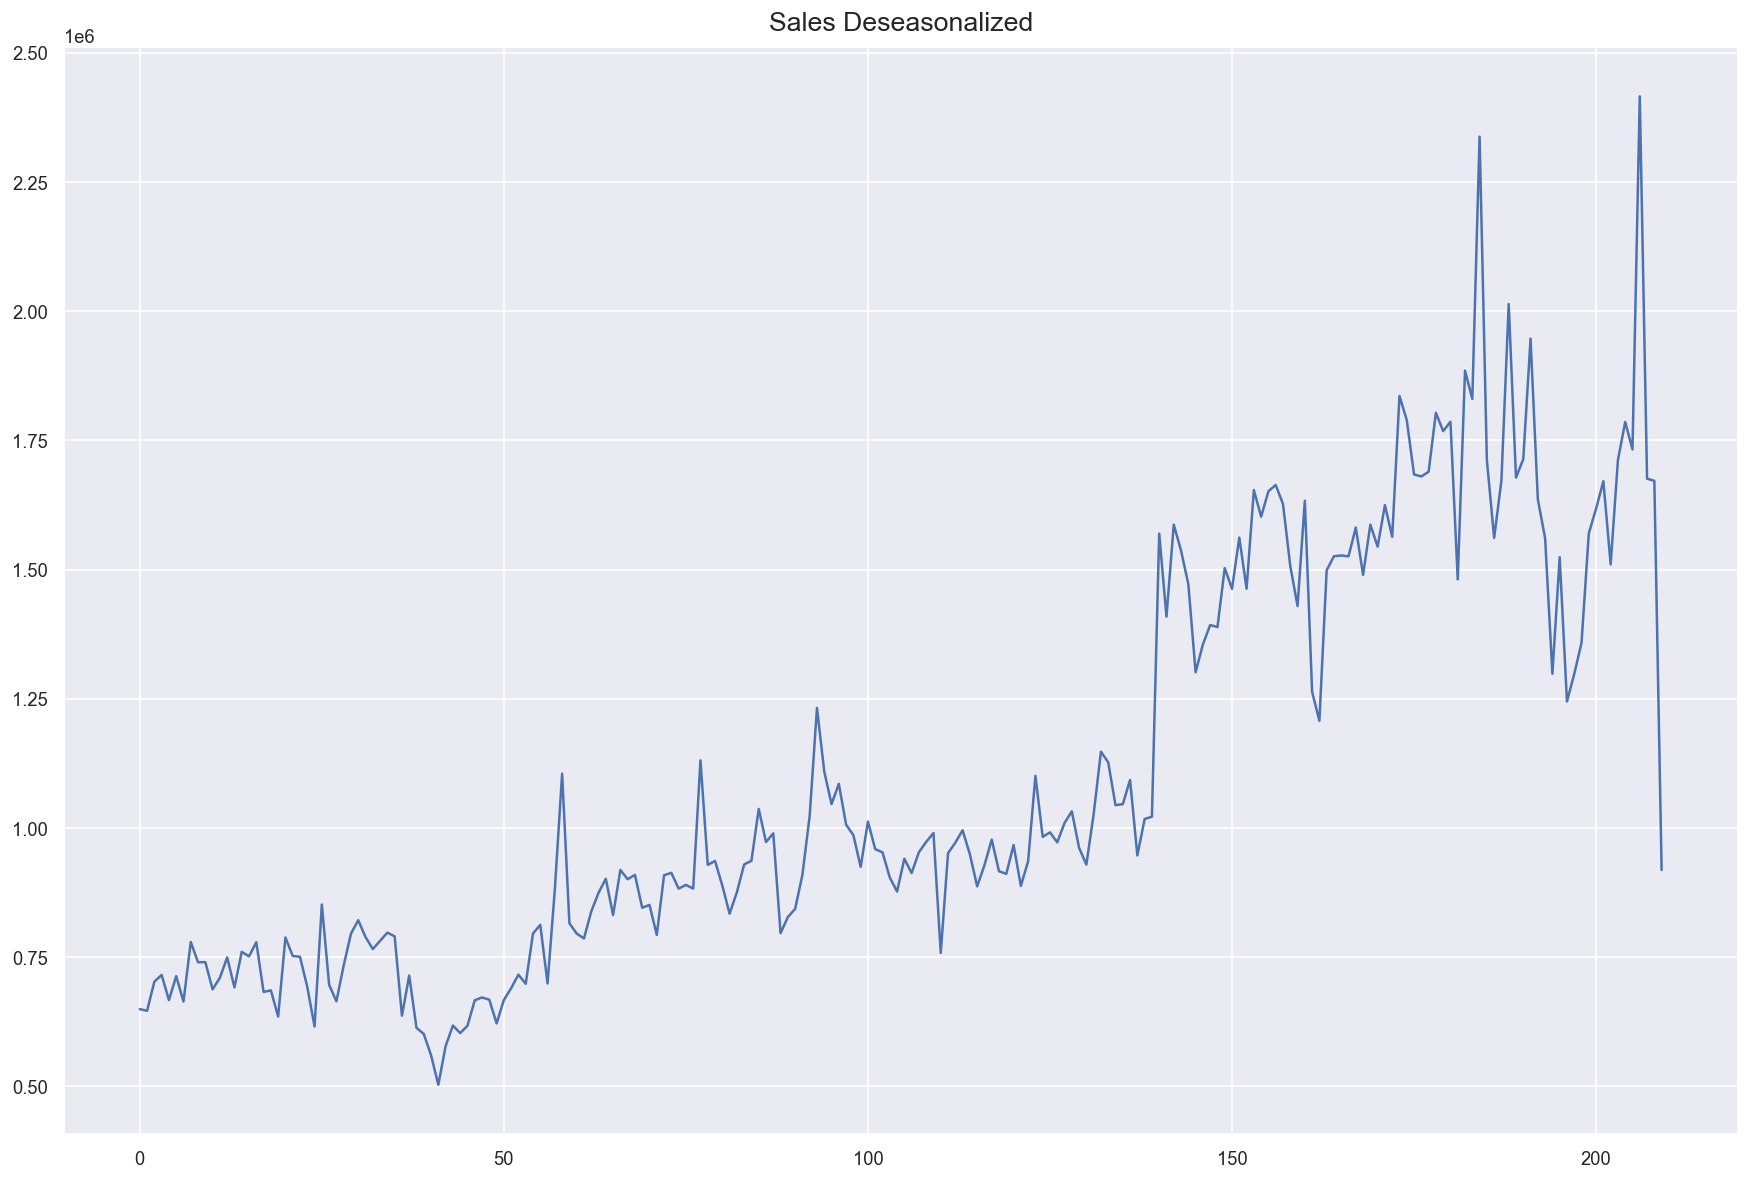

In [747]:
result_mul = seasonal_decompose(df['sales'].values, model='multiplicative', period=52)
deseasonalized = df['sales'].values / result_mul.seasonal
plt.plot(deseasonalized)
plt.title('Sales Deseasonalized', fontsize=16)
plt.plot()

Detrending and deasonalization show both a nonconstant variance and seasonality

Text(0.5, 1.0, 'Sales detrended')

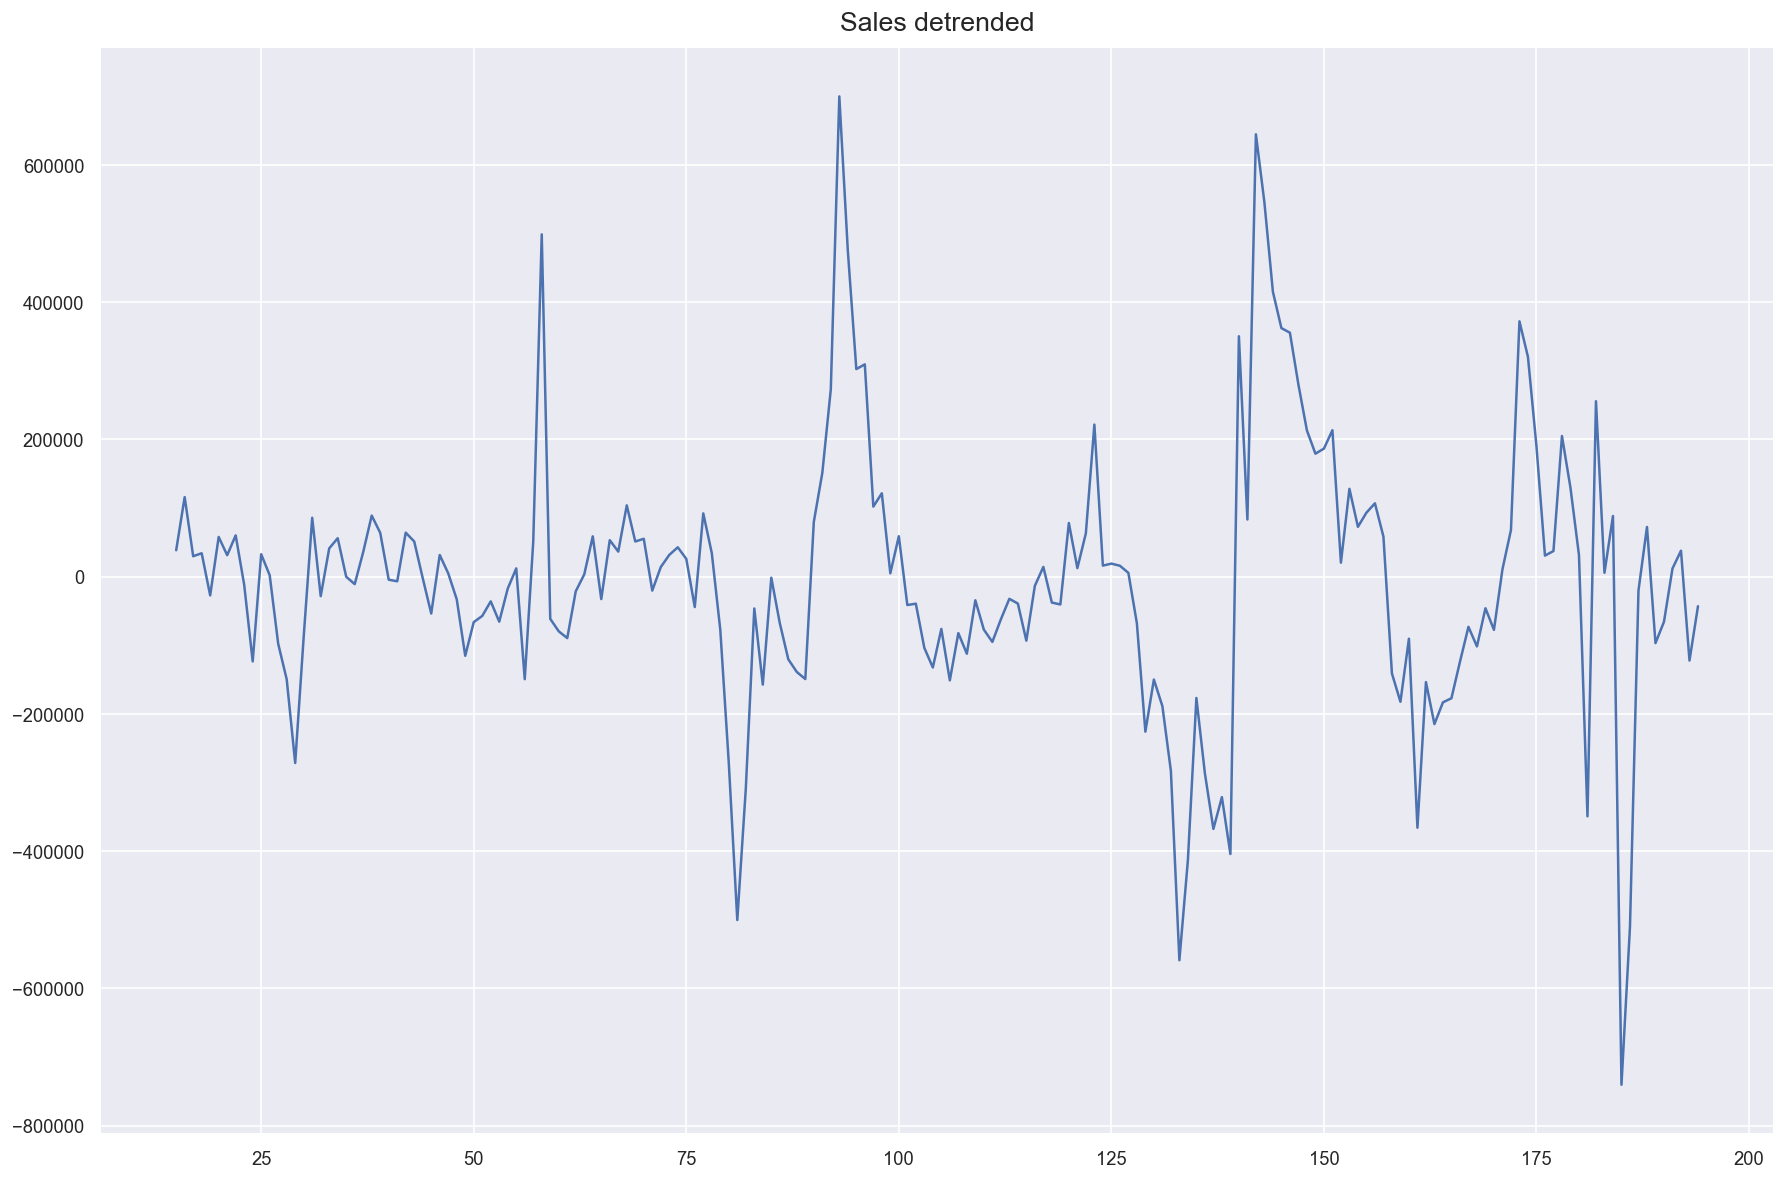

In [748]:
result_mul = seasonal_decompose(df['sales'].values, model='multiplicative', period=30)
detrended = df['sales'].values - result_mul.trend
plt.plot(detrended)
plt.title('Sales detrended', fontsize=16)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

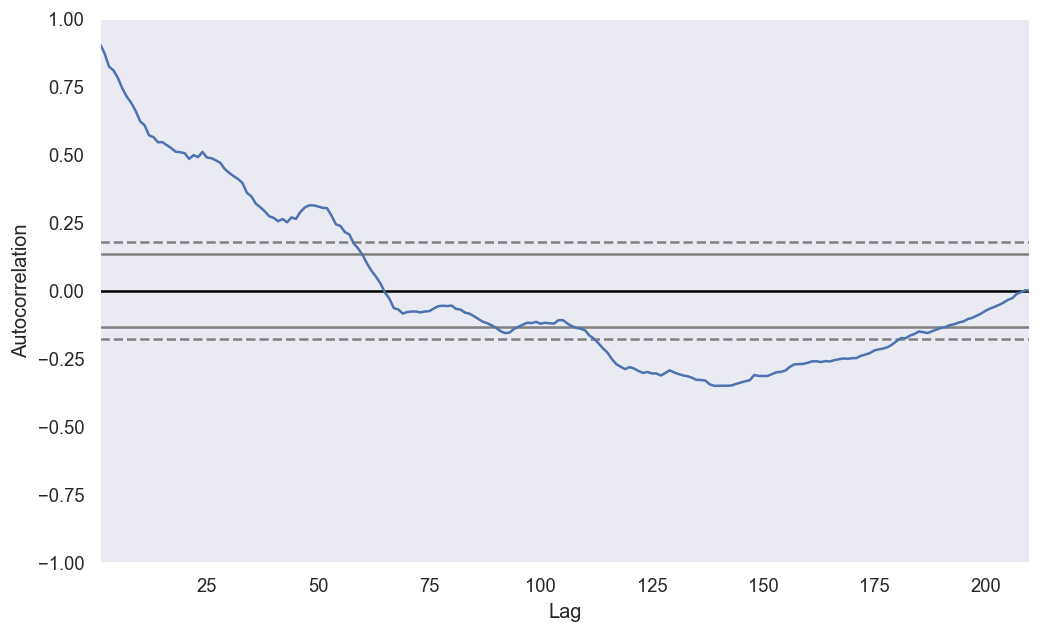

In [749]:
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(df['sales'].tolist())

Spikes demonstrate seasonality with slight degree of autocorrelation

C:\Users\norri\.conda\envs\mercury-ds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


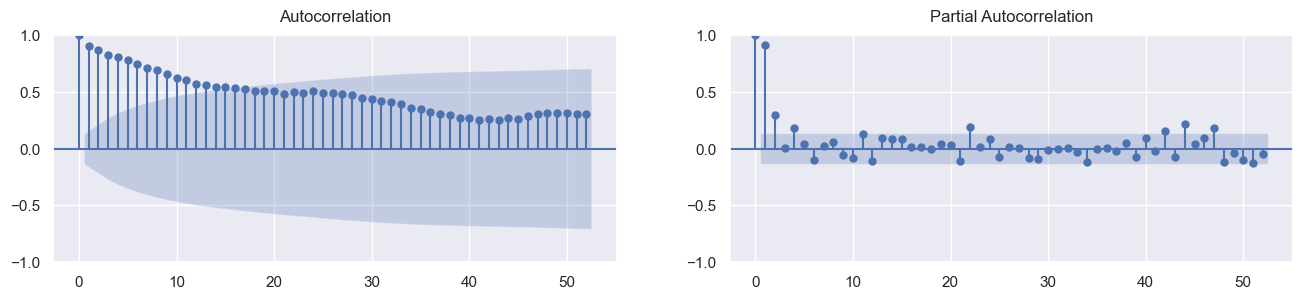

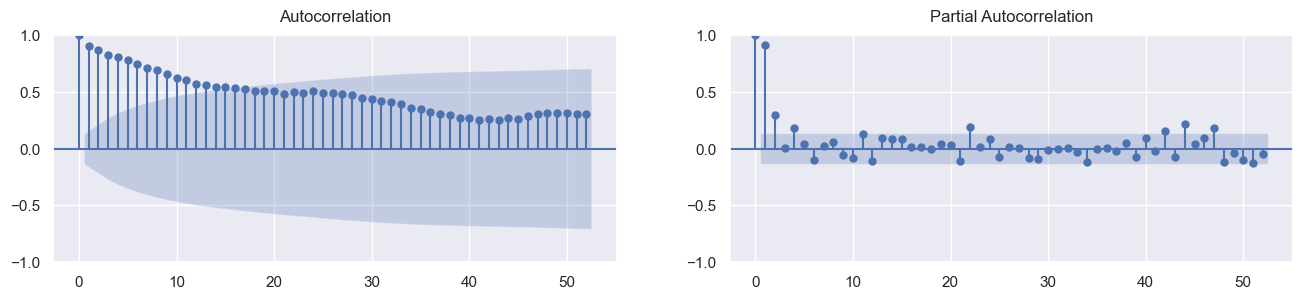

In [750]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)
plot_acf(df['sales'].tolist(), lags=52, ax=axes[0])
plot_pacf(df['sales'].tolist(), lags=52, ax=axes[1])

Similar annual seasonality trends appear with peaks and valleys
on weekly basis

In [751]:
ac1 = df['sales'].autocorr(lag=1)
print("One week Lag: ", ac1)
ac2 = df['sales'].autocorr(lag=2)
print("Two week Lag: ", ac2)
ac3 = df['sales'].autocorr(lag=3)
print("Three week Lag: ", ac3)
ac4 = df['sales'].autocorr(lag=4)
print("Four Week Lag: ", ac4)
ac5 = df['sales'].autocorr(lag=5)
print("Five Week Lag: ", ac5)
ac6 = df['sales'].autocorr(lag=6)
print("Six Week Lag: ", ac6)
ac7 = df['sales'].autocorr(lag=7)
print("seven Week Lag: ", ac7)
ac8 = df['sales'].autocorr(lag=8)
print("Eight Week Lag: ", ac8)
ac9 = df['sales'].autocorr(lag=9)
print("Nine Week Lag: ", ac9)
ac10 = df['sales'].autocorr(lag=10)
print("Ten Week Lag: ", ac10)
ac11 = df['sales'].autocorr(lag=11)
print("Eleven Week Lag: ", ac11)
ac12 = df['sales'].autocorr(lag=12)
print("Twelve Week Lag: ", ac12)

One week Lag:  0.9098153102364003
Two week Lag:  0.8821806039294661
Three week Lag:  0.8389246955797052
Four Week Lag:  0.8490497092696655
Five Week Lag:  0.8279749295809783
Six Week Lag:  0.7972397702030303
seven Week Lag:  0.7741044310663454
Eight Week Lag:  0.7569161243131861
Nine Week Lag:  0.7337078457624796
Ten Week Lag:  0.7031688420379568
Eleven Week Lag:  0.6983477370843819
Twelve Week Lag:  0.6648409440726896


Demonstration of small autocorrelation with lag

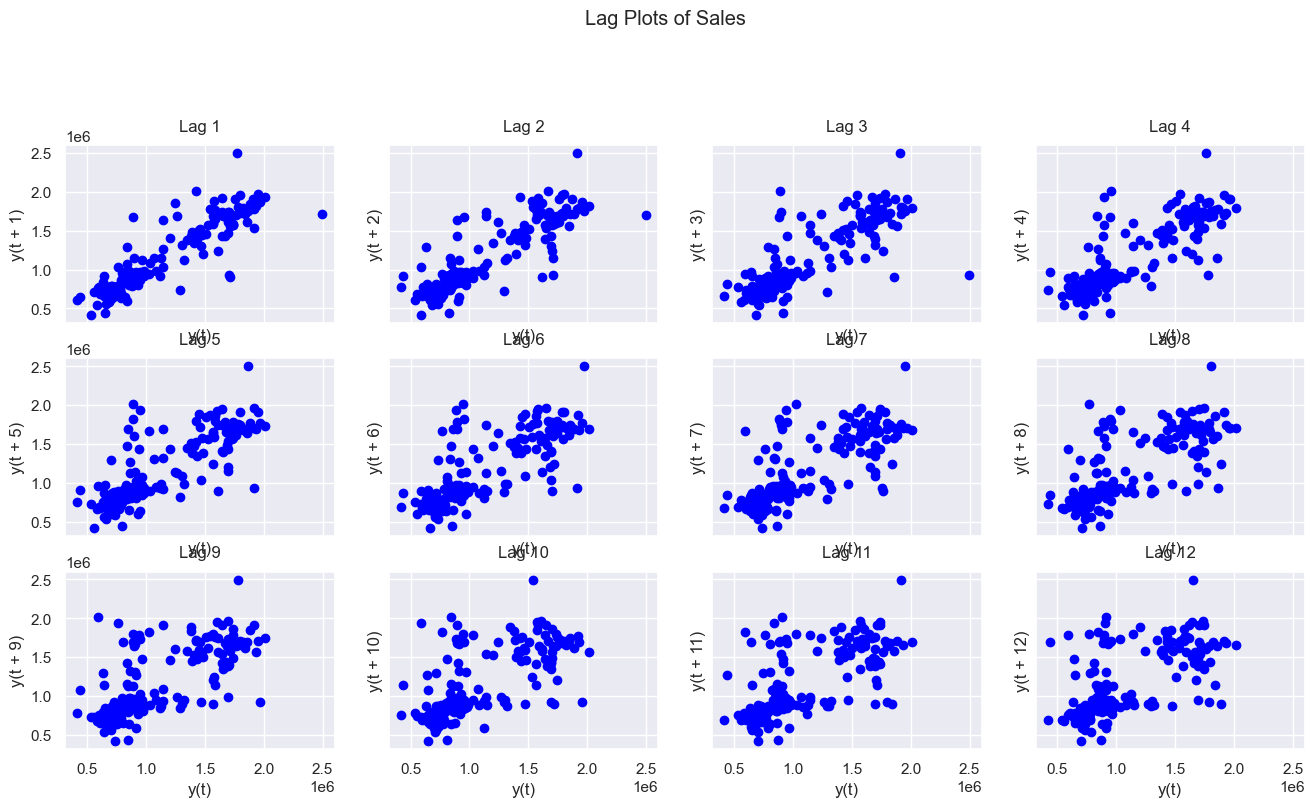

In [752]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})
fig, axes = plt.subplots(3, 4, figsize=(16, 8), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:12]):
    lag_plot(df['sales'], lag=i+1, ax=ax, c='blue')
    ax.set_title('Lag ' + str(i+1))
fig.suptitle('Lag Plots of Sales', y=1.05)
plt.show()

Decreasing linear trend between lag plots demonstrates similar results to
lag scores, suggesting some positive autocorrelation between first week

In [753]:
X_train, X_test, y_train, y_test = train_test_split(df['week'], df['sales'],
                                                    test_size=0.33,
                                                    random_state=42)
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)
forecast = model.predict(n_periods=len(y_test))
forecast = pd.DataFrame(forecast,index = y_test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4030.918, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4030.398, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4031.259, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4030.581, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4309.057, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4031.085, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.643 seconds


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.396e+12   2.45e+11      5.705      0.000    9.16e+11    1.88e+12


C:\Users\norri\.conda\envs\mercury-ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\norri\.conda\envs\mercury-ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


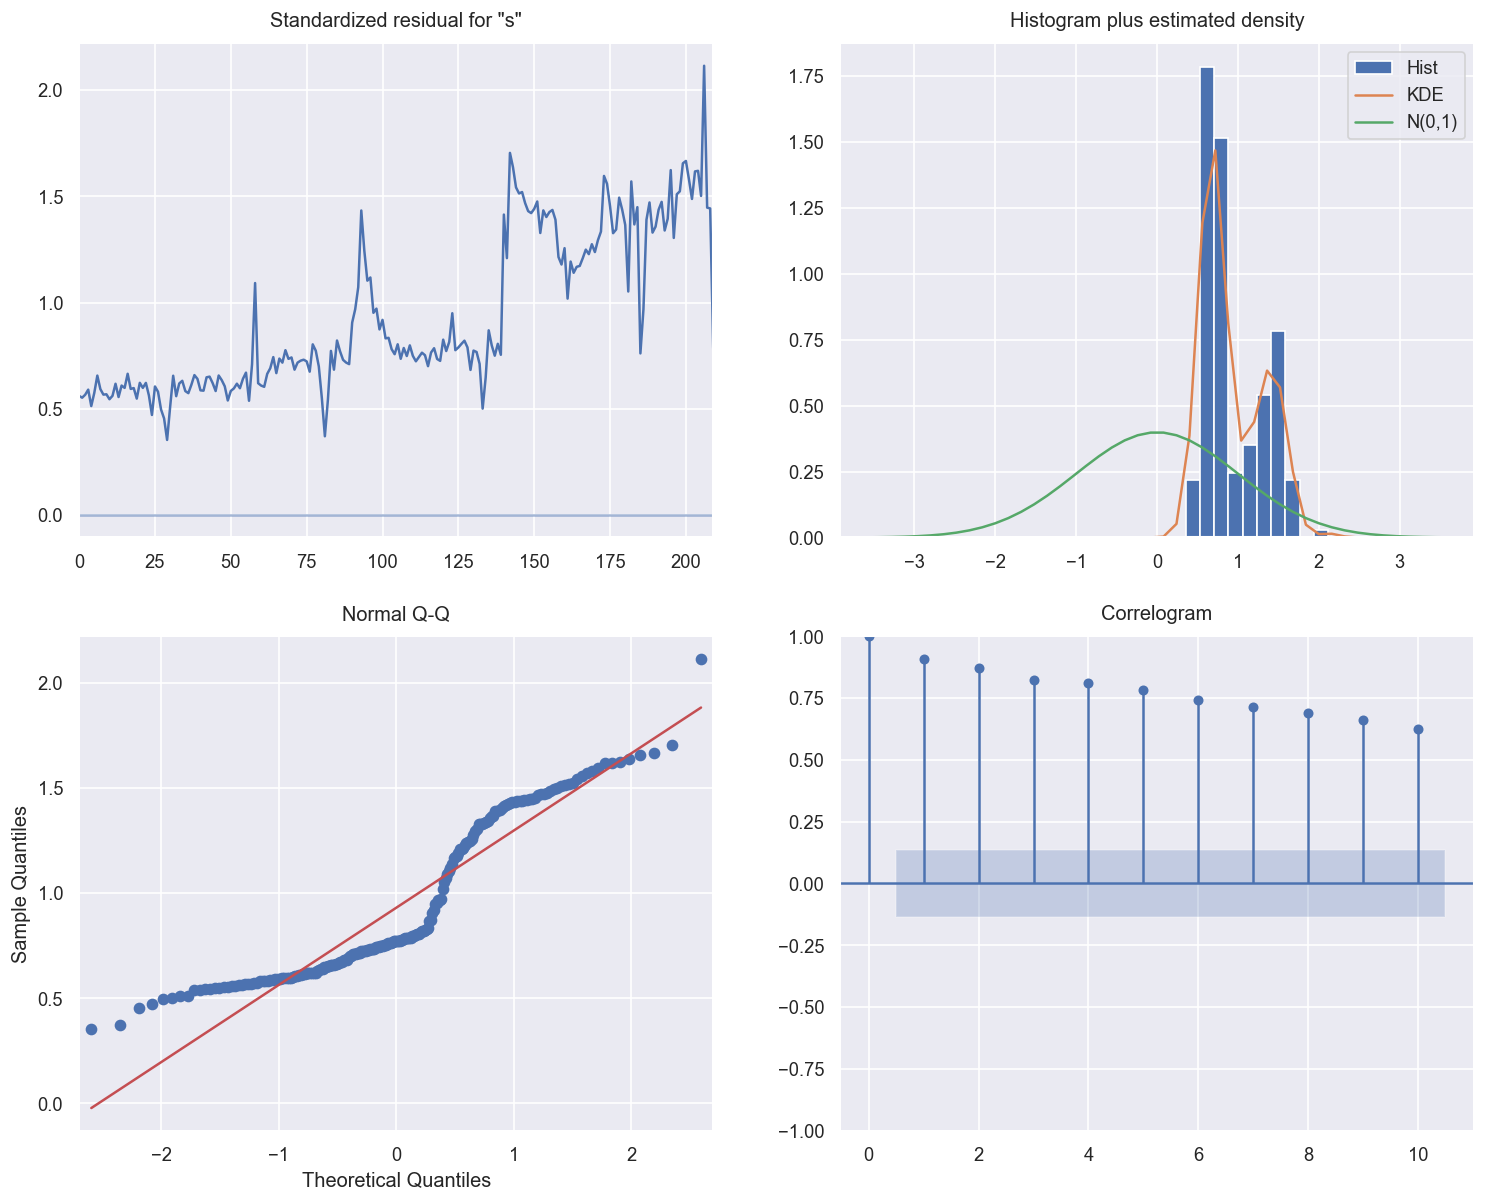

In [754]:
mod = sm.tsa.statespace.SARIMAX(df['sales'],
                                order=(0, 0, 0),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Bimodal distribution of residuals suggests model error is not fully corrected
for in ARIMA estimates

In [755]:
df_small = df[['week', 'sales']]

In [756]:
result = adfuller(df_small.sales.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.760572
p-value: 0.400205


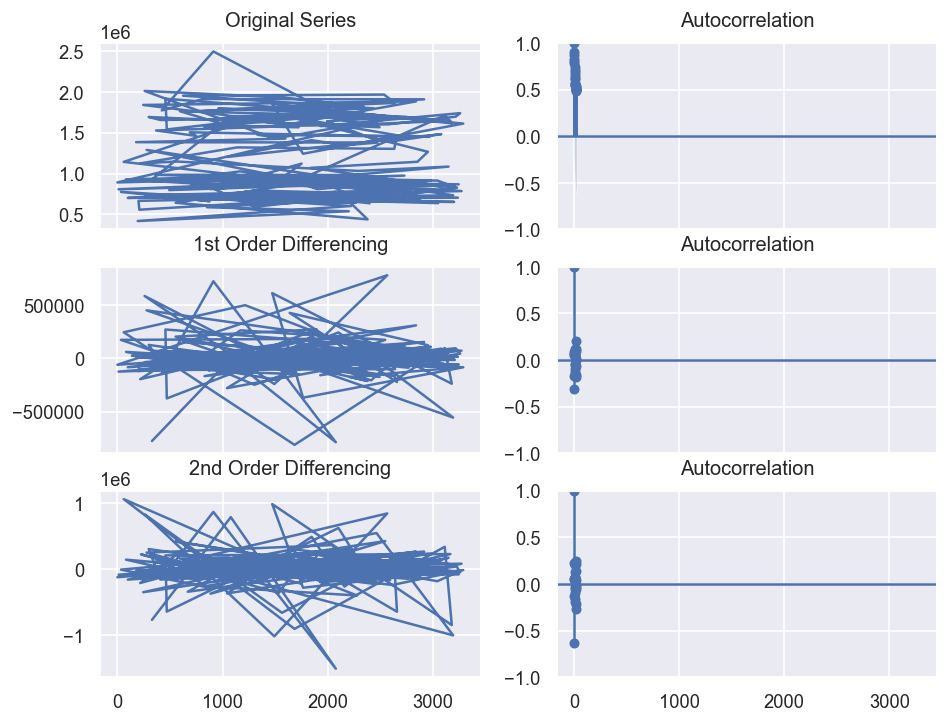

In [757]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_small.sales); axes[0, 0].set_title('Original Series')
plot_acf(df_small.sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_small.sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_small.sales.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_small.sales.diff().diff()); axes[2, 0].set_title('2nd Order '
                                                                  'Differencing')
plot_acf(df_small.sales.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [758]:
y = df_small.sales
print(ndiffs(y, test='adf'))  # Adf Test
print(ndiffs(y, test='kpss'))  # KPSS test
print(ndiffs(y, test='pp')) # PP test

0
1
0


In [759]:
# # PACF plot
# plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
# np_df = df_small
# np_df[['sales']]
# np_df.to_numpy

<bound method DataFrame.to_numpy of            week       sales
1387 2018-06-03   662170.37
3203 2018-06-10   652171.79
2153 2018-06-17   668735.46
1959 2018-06-24   697074.12
1068 2018-07-01   605821.35
...         ...         ...
422  2022-05-08  1774080.46
913  2022-05-15  2497726.59
2078 2022-05-22  1709048.56
1079 2022-05-29  1704391.83
329  2022-06-05   927193.92

[210 rows x 2 columns]>

C:\Users\norri\.conda\envs\mercury-ds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


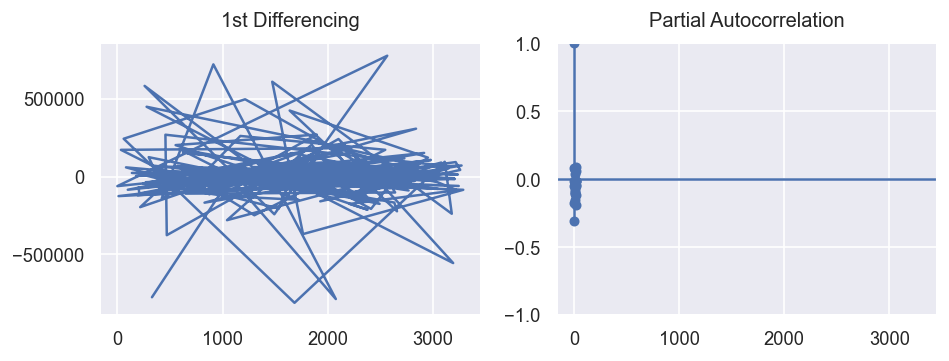

In [772]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df['sales'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df['sales'].diff().dropna(), ax=axes[1])
plt.show()

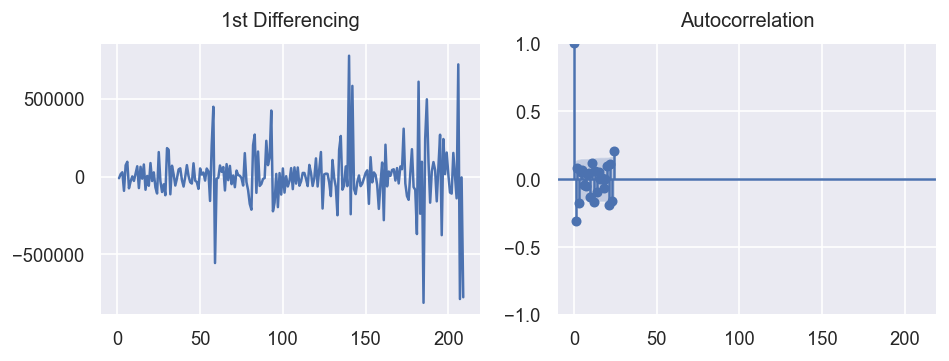

In [770]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_small['sales'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df['sales'].diff().dropna(), ax=axes[1])
plt.show()

In [762]:
# Create Training and Test
df_small = df = df_small.sort_values(by=['week'])
df_small = df_small.reset_index()
df_small = df_small[['week', 'sales']]
train = df_small['sales'][:85]
test = df_small['sales'][85:]

In [763]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2200.952, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2200.002, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2196.011, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2198.977, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2186.486, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2187.050, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2185.483, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2194.296, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2187.452, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2187.352, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2187.517, T

In [764]:
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  698201.544094082


In [765]:
model = ARIMA(train, order=(3, 2, 1))
fitted = model.fit(method='statespace')
print(fitted.summary())
# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   85
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -1088.832
Date:                Fri, 15 Jul 2022   AIC                           2187.664
Time:                        22:22:19   BIC                           2199.759
Sample:                             0   HQIC                          2192.523
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1538      0.087     -1.767      0.077      -0.324       0.017
ar.L2         -0.3605      0.146     -2.477      0.013      -0.646      -0.075
ar.L3         -0.1457      0.149     -0.975      0.3

TypeError: 'float' object is not subscriptable

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc_series, test.values)

In [ ]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.title('#Passenger Prediction')
plt.xlabel('Date')
plt.ylabel('Actual #Passenger')
plt.legend(loc='upper left', fontsize=8)
plt.show()